# SUVAT equations used on running data

#### Download running data
The first thing you need to do is to download your running data which will include the latitude and longitude points as well as the time stamps when it was recorded.

- Log into www.strava.com
- Go to the [event](https://www.strava.com/activities/3409137155) you want to use to download your data (this one you won't be able to download).
- Select the three dots on the left middle of the screen.
- Click **export GPX**.

In [1]:
from bs4 import BeautifulSoup as Soup
import numpy as np
from math import sin, cos, atan2, sqrt, pi
from datetime import datetime
import matplotlib.pyplot as plt

FORMAT = '%H:%M:%S'

#### Extract GPS data

You can use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to parse and extract the data you need from the .gpx data that you downloaded.

In [2]:
soup = Soup(open("Evening_run.gpx"))
run_data = soup.findAll("trkpt")

latitude = []
longitude = []
t = []
elevation = []

for tag in run_data:
    latitude.append(str(tag).split('lat="',1)[1].split('" lon=',1)[0])
    longitude.append(str(tag).split('lon="',1)[1].split('">',1)[0])
    time_stamp = tag.find("time").text.split("T",1)[1].split("Z",1)[0]
    t.append(datetime.strptime(time_stamp, FORMAT))
    elevation.append(tag.find("ele").text)
    
elevation = np.asarray(elevation, dtype=np.float32)

#### Calculate distances between GPS points

You have to calculate the distance between latitude and longitude in meters. The equation to do this is found [here](http://www.movable-type.co.uk/scripts/latlong.html).

In [3]:
def distance(latitude, longitude):
    R = 6378 #radius of the earth (km)
    latitude = np.array(latitude)
    longitude = np.array(longitude)
    a = (sin(deg2rad(np.diff(latitude))/2))**2 + cos(deg2rad(latitude[0])) * cos(deg2rad(latitude[1])) * (sin(deg2rad(np.diff(longitude))/2))**2
    c = 2 * atan2( sqrt(a), sqrt(1-a) )
    d = R * c 
    return 1000*d #m

def deg2rad(deg): 
    return deg * pi/180

#### Calculate velocity and acceleration

The next thing you need to determine is $\Delta t$ to ensure we can calculate the correct $v_{average}$. This can be done by using the python library `datetime`.

In [4]:
dt = np.zeros(len(t))
dx = np.zeros(len(dt))

for i in range(1,len(longitude)):
    long = [float(longitude[i-1]),
        float(longitude[i])]
    lat = [float(latitude[i-1]),
        float(latitude[i])]
    dx[i] = distance(lat,long)
    dt[i] = (t[i]-t[i-1]).seconds
cumulative_t = np.cumsum(dt)
cumulative_x = np.cumsum(dx)


Now that we have the `dx` and `dt` variables populated with the running data, we can use the following equations:
$$v_{avg}=\frac{\Delta x}{\Delta t}$$
Average velocity can also be expressed as:
$$v_{avg}=\frac{u+v}{2}$$
And when we have the beginning velocity ($u$) and the end velocity ($v$), we can calculate acceleration:
$$a = \frac{v-u}{t}$$

In [5]:
v_avg = np.zeros(len(dx))
u = np.zeros(len(dx))
v = np.zeros(len(dx))
a = np.zeros(len(dx))

for i in range(1,len(v_avg)):
    v_avg[i] = dx[i]/dt[i]
for i in range(1,len(u)):
    v[i] = 2*v_avg[i] - u[i-1]
    u[i] = v[i]
    a[i] = (v[i]-u[i-1])/dt[i]   

#### Determine running pace

We can calculate the average pace for the whole run with:

$$pace = \frac{time}{distance}$$

In [6]:
print(f"Total time jogging: {int(np.sum(dt)/60)}:0{int(np.sum(dt)%60)} minutes")
print(f"Total distance: {round(np.sum(dx)/1000,2)} km")
print(f"Pace: {int((np.sum(dt)/(np.sum(dx)/1000)//60))}:{int((np.sum(dt)/(np.sum(dx)/1000)%60))} min/km")

Total time jogging: 25:07 minutes
Total distance: 4.37 km
Pace: 5:44 min/km


# Determining energy required during a run

#### Using Newton's second law
We can use Newton's second law to determine the total force for each time step:

$$\Sigma F = ma$$

We have determined the acceleration ($a$) from the GPS data, $m$ is the mass of the runner and $\Sigma F$ is the sum of forces which include forces due to gravity and air resistance. The equation can be rewritten as:

$$F_{total} = ma + F_{elevation} + F_{A}$$

#### Gravitational forces

We can calculate the forces due to elevation by using the `elevation` data given by the GPS smart watch.

First we need to determine the angle of the decline or inclinde at a given timestep:

$$\theta = tan^{-1}\frac{elevation}{\Delta t}$$

After the angle is known, the component of the gravitational force that propels or brakes the runner, can be calculated:

$$F_{elevation} = mgsin\theta$$

where $m$ is the mass of the runner and $g$ is the gravimetrical acceleration (9.81 $m/s^2$).

In [7]:
elevation

array([  53.6,  -57.6, -113.4, -141.2, -155.2, -162. , -165.6, -167.6,
       -168.8, -169. , -169.2, -169.2, -169. , -169.2, -169.2, -168.8,
       -169.2, -169.2, -169.2, -169.2, -169.2, -169.2, -169.2, -169.2,
       -169.2, -169.2, -169.4, -169.4, -169.4, -169.4, -169.4, -169.6,
       -169.6, -169.6, -169.8, -169.8, -169.8, -169.8, -169.8, -169.8,
       -169.8, -170.2, -170.6, -170.6, -170.8, -171. , -171. , -171. ,
       -171. , -171.2, -171.2, -171. , -170.8, -170. , -169.6, -169. ,
       -168.6, -167.8, -167.4, -167. , -166.4, -165.4, -165.4, -165.2,
       -164.6, -164.2, -163.8, -163.4, -163.2, -162.8, -162.6, -162.8,
       -163. , -163.8, -164.2, -164.6, -164.8, -165.2, -165.6, -166.2,
       -166.2, -167. , -167. , -166. , -165.2, -164.2, -163.2, -162.2,
       -162.2, -163.2, -163.2, -164. , -164.2, -164.8, -165.4, -166.2,
       -166.4, -166.4, -166.4, -166.2, -165.6, -165.4, -164.6, -164.4,
       -163.4, -162.4, -162.2, -162. , -162.2, -162.2, -162.2, -162.2,
      

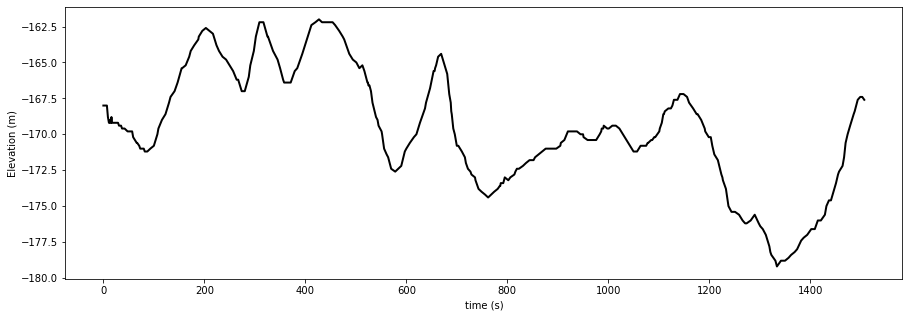

In [8]:
elevation[0:8] = -168
# First line
fig, ax = plt.subplots(figsize=(15,5))
color = 'black'
ax.set_xlabel('time (s)')
ax.set_ylabel('Elevation (m)', color=color)
ax.plot(cumulative_t, elevation, 'black', linewidth=2)

In [9]:
theta = np.zeros(len(cumulative_t))
F_elevation = np.zeros(len(cumulative_t))

m = 80 # kg
g = 9.81 #m/s^2

for i in range(1,len(cumulative_t)):
    theta[i] = np.arctan((elevation[i]-elevation[i-1])/dt[i]) #-ve gravity helping. +ve gravity slowing you down
    F_elevation[i] = m*g*np.sin(theta[i])

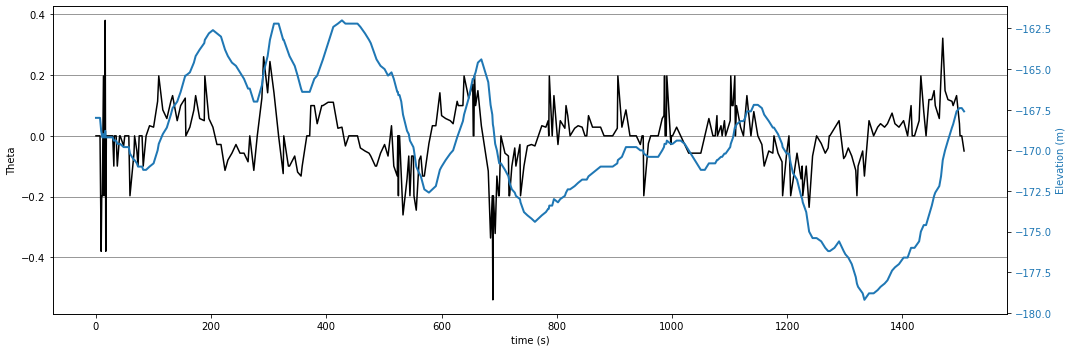

In [10]:
fig, ax1 = plt.subplots(figsize=(15,5))

color = 'black'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Theta', color=color)
ax1.plot(cumulative_t,theta, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(color='grey', which='major', axis='y', linestyle='solid')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Elevation (m)', color=color)  # we already handled the x-label with ax1
ax2.plot(cumulative_t,elevation, color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

#plt.plot(cumulative_t,theta,'black', linewidth=1)
#plt.plot(cumulative_t,elevation,'red', linewidth=1)

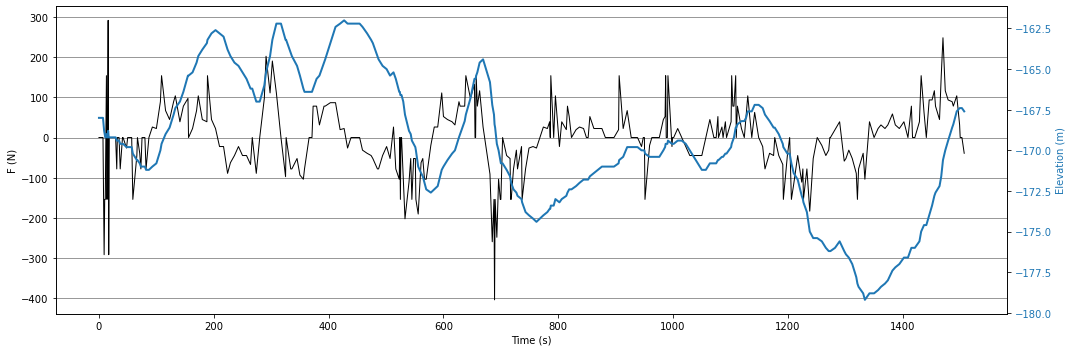

In [11]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))

color = "black"
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('F (N)', color=color)
ax1.plot(cumulative_t,F_elevation,color=color, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(color='grey', which='major', axis='y', linestyle='solid')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Elevation (m)', color=color)  # we already handled the x-label with ax1
ax2.plot(cumulative_t,elevation, color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

#### Air resistance

Air resistance can be calculated as:

$$F_A = \frac{1}{2} \rho v^2 C_D A$$

where $\rho$ is the density of air, $v$ is the velocity of the runner, $C_D$ is the coefficient of drag and $A$ is the frontal area of the runner.

In [20]:
C_D = 0.9
A = 1.8*1 #m^2
rho_air = 1.2 #kg/m^3

F_A = np.zeros(len(cumulative_t))

for i in range(1,len(cumulative_t)):
    F_A[i] = 0.5*rho_air*(v_avg[i])**2*C_D*A

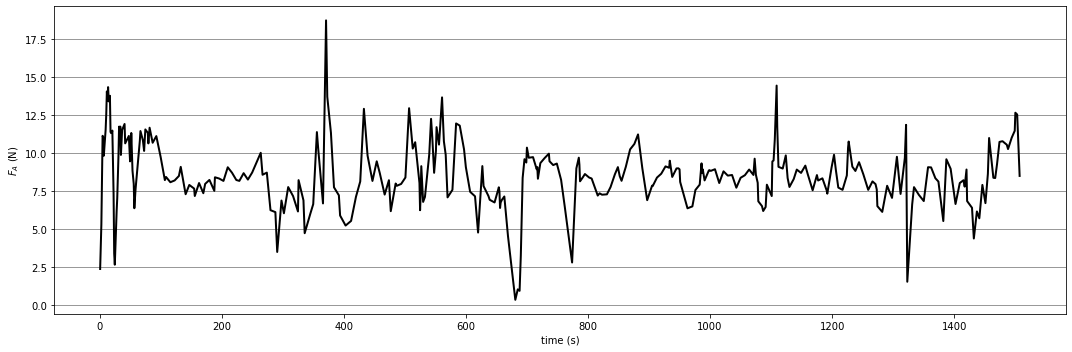

In [21]:
fig, ax1 = plt.subplots(figsize=(15,5))
color = 'black'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('$F_A$ (N)', color=color)
ax1.plot(cumulative_t[1:],F_A[1:],color=color, linewidth=2)
ax1.grid(color='grey', which='major', axis='y', linestyle='solid')
fig.tight_layout() 

In [22]:
F_total = m*a*(a>0) + F_A + F_elevation

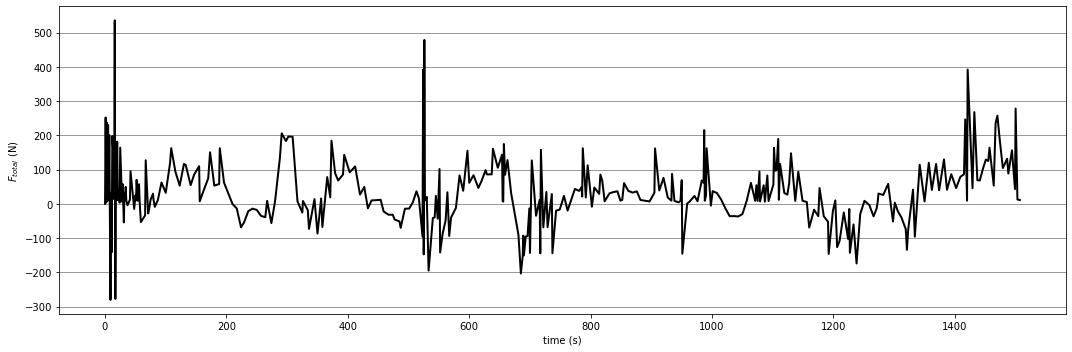

In [23]:
fig, ax1 = plt.subplots(figsize=(15,5))
color = 'black'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('$F_{total}$ (N)', color=color)
ax1.plot(cumulative_t,F_total,'black', linewidth=2)
ax1.grid(color='grey', which='major', axis='y', linestyle='solid')
fig.tight_layout() 

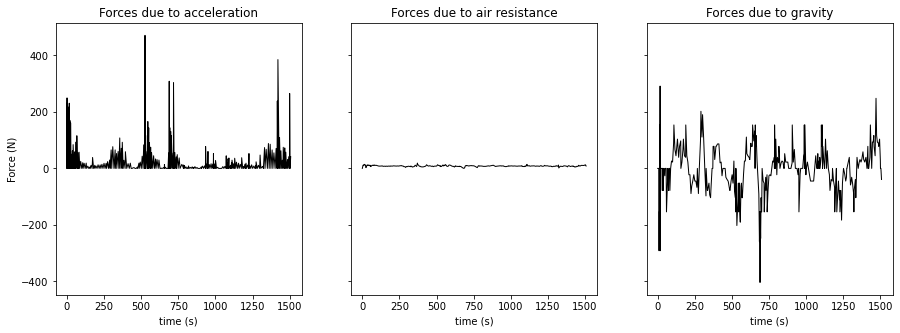

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.plot(cumulative_t, m*a*(a>0), 'black', linewidth=1)
ax1.set_title("Forces due to acceleration")
ax2.plot(cumulative_t, F_A, 'black', linewidth=1)
ax2.set_title("Forces due to air resistance")
ax3.plot(cumulative_t, F_elevation, 'black', linewidth=1)
ax3.set_title("Forces due to gravity")

for ax in [ax1, ax2, ax3]:
    ax.set(xlabel='time (s)', ylabel='Force (N)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in [ax1, ax2, ax3]:
    ax.label_outer()


In [25]:
E = F_total[1:]*(F_total[1:]>0)*dx[1:]
print(f"Total energy: {round(np.sum(E),2)} J")

Total energy: 186934.54 J


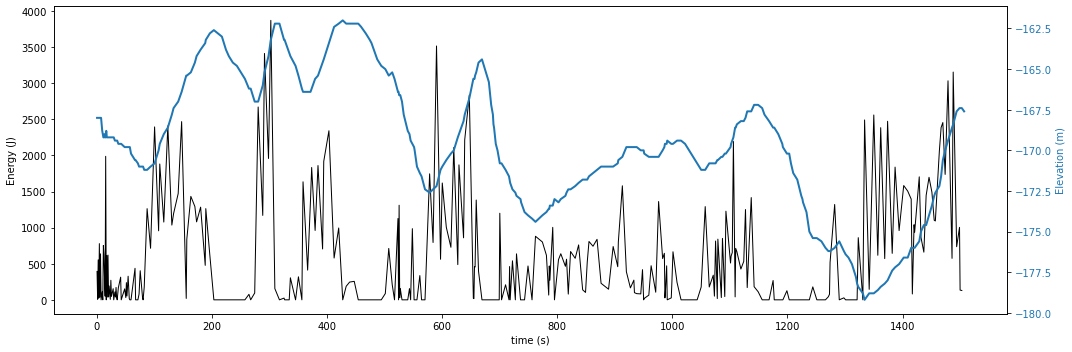

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
color = 'black'
ax.set_xlabel('time (s)')
ax.set_ylabel('Energy (J)', color=color)
ax.plot(cumulative_t[:-1],E,'black', linewidth=1)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Elevation (m)', color=color)  # we already handled the x-label with ax1
ax2.plot(cumulative_t,elevation, color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()